# **Natural Language Processing with Disaster Tweets**

#### *The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).*</br>
#### *The goal of this projects is to build a machine learning model that predicts which Tweets are about real disasters and which ones aren't. This dataset is about 10,000 tweets that were labeled with 0 and 1.*

#### **Acknowledgments**
This Kaggle dataset can be found here: https://www.kaggle.com/competitions/nlp-getting-started/data

This dataset was created by the company figure-eight and originally shared on their 'Data For Everyone' website (page was not found).

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

# **1. Data**

#### Loading required packages and data

In [16]:
import pandas as pd
from google.colab import drive
import numpy as np

In [ ]:
import keras_nlp
import keras

In [2]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
#from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification


In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
file_path = '/content/train.csv'
df = pd.read_csv(file_path)

In [9]:
file_path_test = '/content/test.csv'
df_test = pd.read_csv(file_path_test)

# **2. EDA**

In [10]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**Checking if data is balanced**

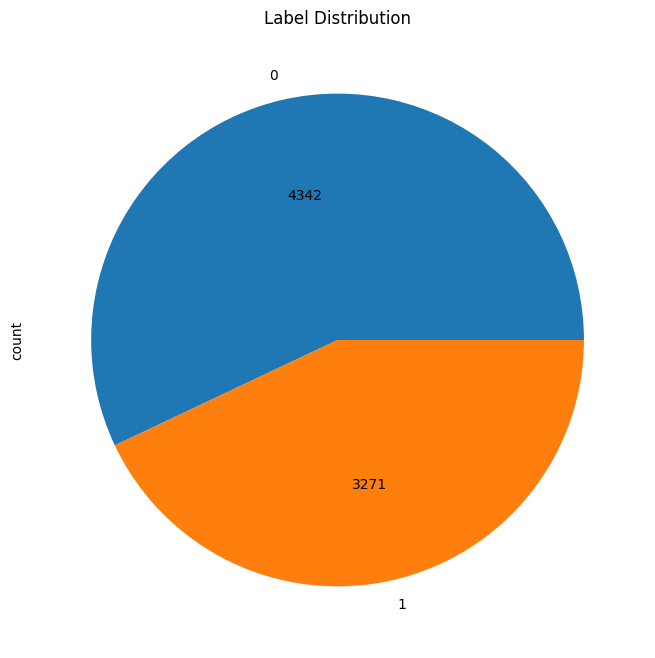

In [8]:
def autopct_counts(pct, all_vals):
    absolute = int(round(pct / 100. * sum(all_vals)))
    return f'{absolute}'

value_counts = df['target'].value_counts()
df['target'].value_counts().plot(
    kind='pie',
    autopct=lambda pct: autopct_counts(pct, value_counts),
    legend=False,
    figsize=(8, 8),
    title="Label Distribution"
)

plt.show()

**Text lenght distribution**

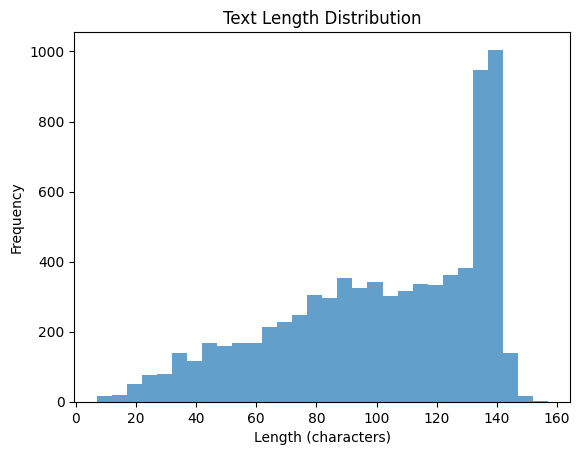

In [9]:
df['text_length'] = df['text'].apply(len)

plt.hist(df['text_length'], bins=30, alpha=0.7)
plt.title('Text Length Distribution')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.show()

**Word Count Distribution**

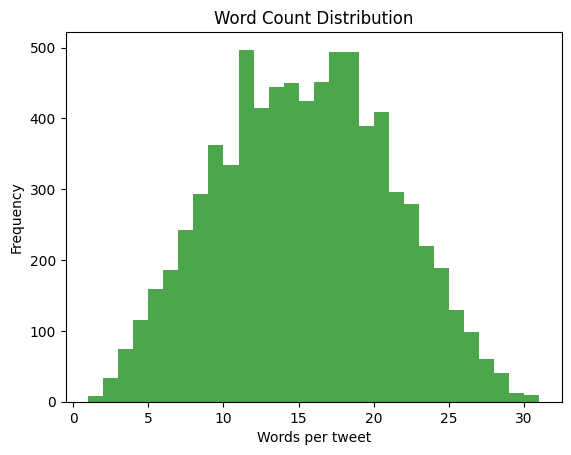

In [10]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Plot distribution of word count
plt.hist(df['word_count'], bins=30, alpha=0.7, color='green')
plt.title('Word Count Distribution')
plt.xlabel('Words per tweet')
plt.ylabel('Frequency')
plt.show()

**Most Common Words - tweets about disaster and regular tweets**

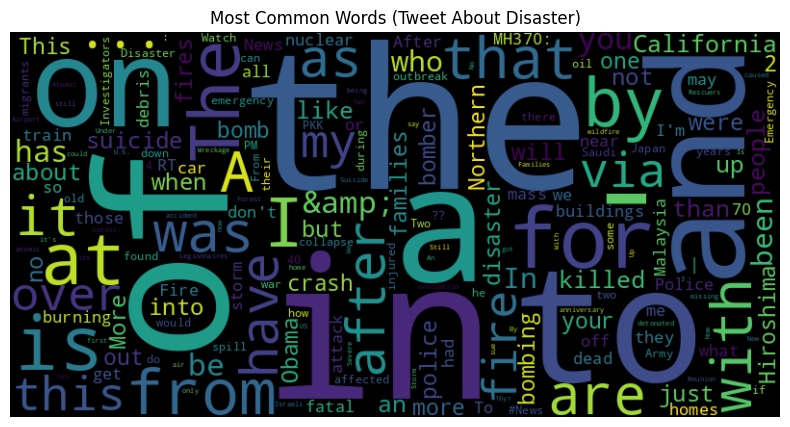

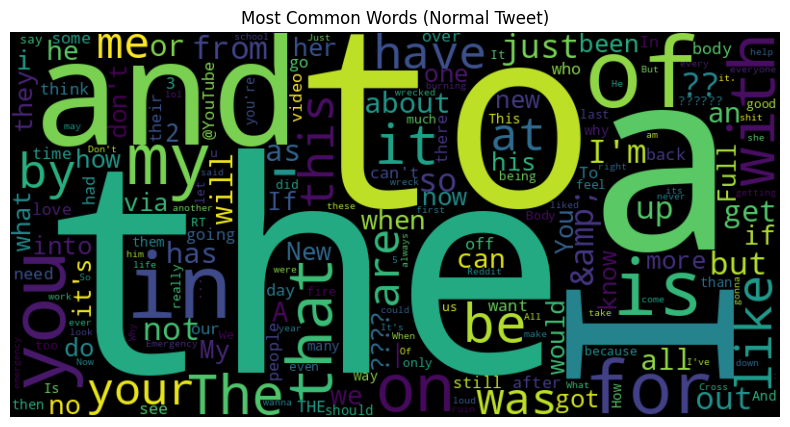

In [15]:
def get_word_frequencies(texts):
    words = ' '.join(texts).split()
    return Counter(words)

text_disaster = df[df['target'] == 1]['text']
text_normal = df[df['target'] == 0]['text']

freq_disaster = get_word_frequencies(text_disaster)
freq_normal = get_word_frequencies(text_normal)

wordcloud_disaster = WordCloud(width=800, height=400).generate_from_frequencies(freq_disaster)
wordcloud_normal = WordCloud(width=800, height=400).generate_from_frequencies(freq_normal)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words (Tweet About Disaster)')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_normal, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words (Normal Tweet)')
plt.show()

### **Note:** In both graphs, we observe a similar set of words regardless of sentiment, making it challenging to differentiate between disaster-related and regular tweets. Therefore, I plan to remove stop words.

In [17]:
# Get stop words set
stop_words = set(stopwords.words('english'))

def clean_text(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

df['cleaned_text'] = df['text'].apply(clean_text)

text_disaster_cleaned = df[df['target'] == 1]['cleaned_text']
text_normal_cleaned = df[df['target'] == 0]['cleaned_text']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


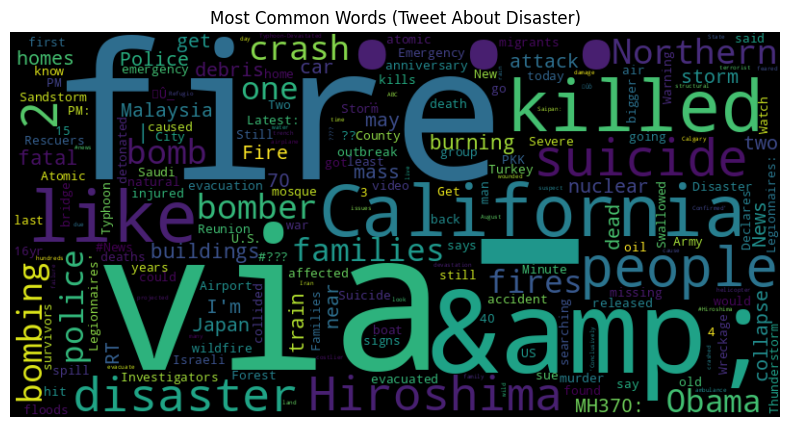

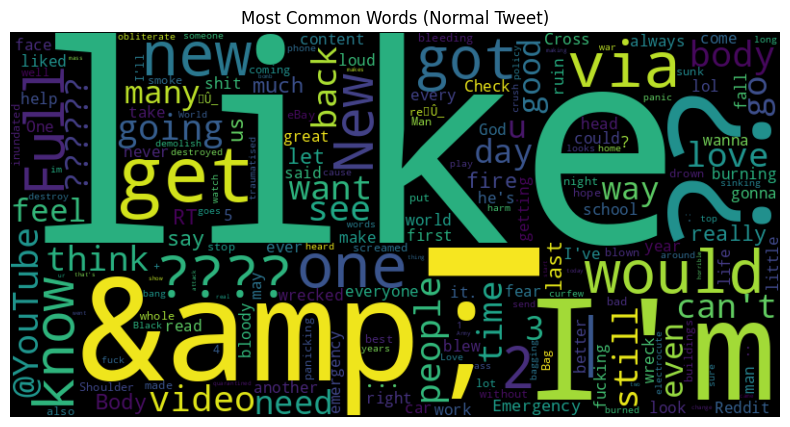

In [18]:
def get_word_frequencies(texts):
    words = ' '.join(texts).split()
    return Counter(words)

freq_disaster_clean = get_word_frequencies(text_disaster_cleaned)
freq_normal_clean = get_word_frequencies(text_normal_cleaned)

wordcloud_disaster_clean = WordCloud(width=800, height=400).generate_from_frequencies(freq_disaster_clean)
wordcloud_normal_clean = WordCloud(width=800, height=400).generate_from_frequencies(freq_normal_clean)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_disaster_clean, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words (Tweet About Disaster)')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_normal_clean, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words (Normal Tweet)')
plt.show()

**I'm confident that the difference of each class is quite evident now.**

# **3. Data Processing, Training and Evaluating**

### 1. My plan is to experiment with both a Deep Learning Model and a Transformer Model:

- GRU: A simplified alternative to LSTMs, also effective for sequence data, while LSTM is well-suited for sequence data it's often excessive for short texts like tweets. So I plan to use GRU for this task and will conduct hyperparameter tuning.
- Following this, I will compare the results with BERT, which excels at capturing context and handling complex language tasks.

### 2. Then will use evaluation metrics such as Accuracy and F1_Score
### 3. I will be using the full text, without removing stop words, because:
- Contextual Understanding: Stop words like "is," "the," "and," and "not" often carry crucial contextual information. For instance, "not good" is very different from "good". It's the case for both - BERT and GRU.
- GRUs (and other recurrent models like LSTMs) are designed to capture dependencies in sequential data. Removing stop words can disrupt the natural structure and flow of text, making it harder for the model to understand context.
- Loss of Semantic Meaning: Stop words contribute to sentence structure, and their removal might lead to a loss of meaning, especially in shorter texts like tweets.


### **3.1. GRU**

**3.1.1 Training**

In [21]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

# Padding
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [22]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['target'], test_size=0.2, random_state=42)

# Convert to numpy arrays
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [23]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    GRU(64, return_sequences=True),
    GRU(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 138ms/step - accuracy: 0.5719 - loss: 0.6851 - val_accuracy: 0.5739 - val_loss: 0.6851
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.5584 - loss: 0.6860 - val_accuracy: 0.5739 - val_loss: 0.6830
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 42s 145ms/step - accuracy: 0.5745 - loss: 0.6856 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 146ms/step - accuracy: 0.5689 - loss: 0.6844 - val_accuracy: 0.5739 - val_loss: 0.6822
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 140ms/step - accuracy: 0.5730 - loss: 0.6835 - val_accuracy: 0.5739 - val_loss: 0.6832


**Just to make sure our assumption was correct about full text vs cleaned (with stop words removed), I will run model on the cleaned data**

In [25]:
tokenizer2 = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer2.fit_on_texts(df['cleaned_text'])
sequences2 = tokenizer2.texts_to_sequences(df['cleaned_text'])

# Padding
max_length = 100
padded_sequences2 = pad_sequences(sequences2, maxlen=max_length, padding='post', truncating='post')
# Split data
X_train2, X_test2, y_train2, y_test2 = train_test_split(padded_sequences2, df['target'], test_size=0.2, random_state=42)

# Convert to numpy arrays
X_train2, X_test2, y_train2, y_test2 = np.array(X_train2), np.array(X_test2), np.array(y_train2), np.array(y_test2)

In [26]:
# Model Definition
model2 = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    GRU(64, return_sequences=True),
    GRU(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile Model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
# Train Model
history2 = model2.fit(X_train2, y_train2, epochs=5, batch_size=32, validation_data=(X_test2, y_test2))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.5450 - loss: 0.6875 - val_accuracy: 0.5739 - val_loss: 0.6833
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.5712 - loss: 0.6861 - val_accuracy: 0.5739 - val_loss: 0.6828
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 42s 151ms/step - accuracy: 0.5690 - loss: 0.6865 - val_accuracy: 0.5739 - val_loss: 0.6823
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.5669 - loss: 0.6851 - val_accuracy: 0.5739 - val_loss: 0.6825
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - accuracy: 0.5772 - loss: 0.6825 - val_accuracy: 0.5739 - val_loss: 0.6826


**We can confirm that the cleaned text with stop words removed does not improve the performance**

**3.1.2 Hyperparameters tuning:**
- val_accuracy doesn't change, so there is no point increasing the number of epochs
- removing dropout
- reducing learning rate
- increasing the number of neurons to capture more complex patterns
- adding early stopping as we see that the accuracy is not improving much with each epoch

In [39]:
# Model Definition
model3 = Sequential([
    Embedding(input_dim=10000, output_dim=100),
    GRU(128, return_sequences=True),
    GRU(64),
    #GRU(32),
    #Dropout(0.5),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
optimazer = tf.keras.optimizers.Adam(learning_rate=0.0005)

# Compile Model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Back to the original text**

In [40]:
history3 = model3.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks = [early_stopping])

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 54s 255ms/step - accuracy: 0.5461 - loss: 0.6871 - val_accuracy: 0.5739 - val_loss: 0.6826
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 79s 242ms/step - accuracy: 0.5657 - loss: 0.6850 - val_accuracy: 0.5739 - val_loss: 0.6829
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.5635 - loss: 0.6867 - val_accuracy: 0.5739 - val_loss: 0.6835
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 47s 247ms/step - accuracy: 0.5721 - loss: 0.6828 - val_accuracy: 0.5739 - val_loss: 0.6839


In [42]:
{'Validation Loss': history3.history['val_loss'][-1],
'Validation Accuracy': history3.history['val_accuracy'][-1]}

{'Validation Loss': 0.6839200258255005,
 'Validation Accuracy': 0.5738673806190491}

**The model performance has not improved, we still get validation accuracy score as 57%**

### **3.2. Moving to BERT**

In [12]:
from sklearn.model_selection import train_test_split
X = df["text"]
y = df["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)

In [21]:
X_test_set = df_test["text"]

In [14]:
# Split the dataset
X = df["text"]
y = df["target"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Load BERT model and preprocessor
bert_model_name = "bert_base_en_uncased"
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    bert_model_name, sequence_length=160
)
bert_classifier = keras_nlp.models.BertClassifier.from_preset(
    bert_model_name, num_classes=2, preprocessor=preprocessor
)

# Compile the model
bert_classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"],
)

In [31]:
bert_classifier.summary()

Preprocessor: "bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     109,482,240 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 328,451,336 (1.22 GB)

 Trainable params: 109,483,778 (417.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 218,967,558 (835.29 MB)

In [17]:
history4 = bert_classifier.fit(
    x=X_train,
    y=np.array(y_train),
    validation_data=(X_val, np.array(y_val)),
    epochs=5,
    batch_size=32,
)

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.7029 - loss: 0.5672 - val_accuracy: 0.8441 - val_loss: 0.3868
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.8409 - loss: 0.3810 - val_accuracy: 0.8336 - val_loss: 0.3752
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.8806 - loss: 0.3143 - val_accuracy: 0.8485 - val_loss: 0.3879
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9084 - loss: 0.2533 - val_accuracy: 0.8231 - val_loss: 0.4565
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9346 - loss: 0.1974 - val_accuracy: 0.8389 - val_loss: 0.4508


**We achieved validation accuracy 84%**

In [22]:
# These are predictions on the training set from the test portion after the split. I plan to display the confusion matrix, but we can only obtain labels from the training set.
predictions = bert_classifier.predict(X_test_set)
y_pred = np.argmax(predictions, axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 33s 322ms/step


In [23]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [25]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred_train = bert_classifier.predict(X_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step


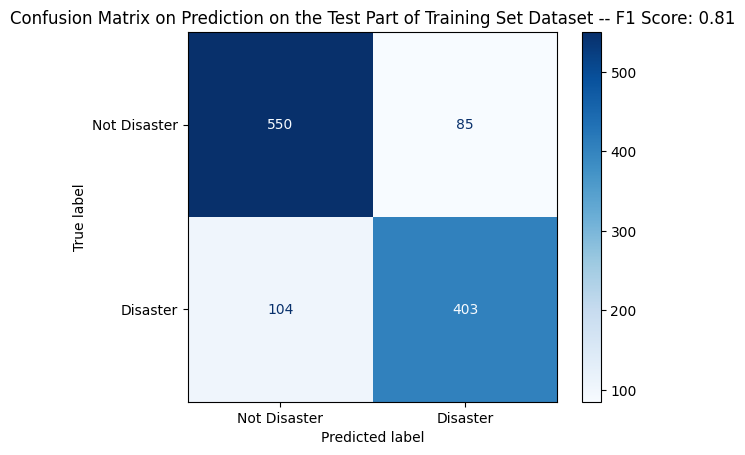

In [29]:
displayConfusionMatrix(y_test, y_pred_train, "Prediction on the Test Part of Training Set")

In [24]:
# These are predictions on the test set for Kaggle competition submission
submission_df = pd.DataFrame({
    'id': df_test['id'],
    'target': (y_pred > 0.5).astype(int).flatten()
})
submission_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [30]:
#output_csv_path = r"C:\Users\irent\Downloads\Deep-Learning\submission_tweet_disaster.csv"
#submission_df[['id', 'target']].to_csv(output_csv_path, index=False)

### **4. Summary / Conclusion:**
In this project, we analyzed a tweets dataset through exploratory data analysis (EDA) and experimented with two models: GRU and BERT. Despite efforts to optimize the GRU model through hyperparameter tuning—such as removing dropout, reducing the learning rate, and increasing the number of neurons to capture more complex patterns — these adjustments did not significantly improve performance. The highest accuracy achieved on the validation dataset with GRU was 57%.

In contrast, BERT outperformed GRU by a significant margin, achieving an accuracy of 84% on the validation dataset. This highlights the strength of transformer-based models like BERT in understanding context and handling complex language tasks, making it a superior choice for this dataset.

To further enhance performance, we could consider the following approaches:
- Model Architecture Enhancements like
Hybrid Models - Combine GRU with pretrained embeddings like BERT or use ensemble methods to leverage the strengths of both models
- Experiment with Hyperparameter tuning such as batch sizes, optimizer types, and different scheduling strategies for learning rate decay